# Import module

In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import math
import scipy.stats as stats

import matplotlib.pyplot as plt
import glob
import os

In [10]:
def getTimeLaps(labels, start_time):
    timeLaps=[]
    old_time, old_label=labels.loc[0][0], labels.loc[0][1]
    for time, label in zip(labels.iloc[:, 0], labels.iloc[:, 1]):
        if old_label != label:
            timeLaps+=[[old_time-start_time, time-start_time]]
            old_time=time
            old_label=label
    timeLaps+=[[old_time-start_time, time-start_time]]
    return timeLaps

def getLabelLaps(labels):
    labelLaps=[]
    old_time, old_label=labels.loc[0][0], labels.loc[0][1]
    labelLaps+=[old_label]
    for time, label in zip(labels.iloc[:, 0], labels.iloc[:, 1]):
        if old_label != label:
            labelLaps+=[label]
            old_time=time
            old_label=label
    labelLaps+=[label]
    return labelLaps

def lowPass(wave, fc, dt):
    N=len(com_acc)

    t = np.arange(0, N*dt, dt)  # 時間軸
    freq = np.linspace(0, 1.0/dt, N)  # 周波数軸
    
    F = np.fft.fft(wave)
    # 正規化 + 交流成分2倍
    F = F/(N/2)
    F[0] = F[0]/2
    
    # 配列Fをコピー
    F2 = F.copy()
    # ローパスフィル処理（カットオフ周波数を超える帯域の周波数信号を0にする）
    F2[(freq > fc)] = 0
    # 高速逆フーリエ変換（時間信号に戻す）
    f2 = np.fft.ifft(F2)
    # 振幅を元のスケールに戻す
    f2 = np.real(f2*N)
    
    return f2

def getTimeCount(unixTime):
    a=[]
    for t in unixTime:
        a.append(t//1000)
        
    time_count=[]
    for t in set(a):
        time_count.append(a.count(t))
    return time_count

def findMinPeak(deltaList):
    return (deltaList[0] >=0 and deltaList[1] <=0)

def findMaxPeak(deltaList):
    return (deltaList[0] <=0 and deltaList[1] >=0)

def step_count(values, times, DIFF_THRESH):
    #RATE_THRESH=80
    RATE_THRESH=400
    
    delta=0
    lastDelta=0
    lastValue=0
    startTime=0
    diff=0
    isPeak=True
    deltaList=[]
    counter=0
    k=0
    #deltaList=[変位, 前変位, 合成加速度, 時間]
    M=[]
    for value, time in zip(values, times):
        if(delta!=0 and lastDelta!=0):
            deltaList+=[[delta, lastDelta, value, time]]
        if startTime==0:
            startTime=time
            
        if (time-startTime)>=RATE_THRESH:
            if (isPeak):
                newHead=0
                for i in range(len(deltaList)):
                    if findMinPeak(deltaList[i]):
                        if (diff < np.abs(deltaList[i][2] - deltaList[0][2])):
                            diff = np.abs(deltaList[i][2] - deltaList[0][2])
                            newHead=i
                if newHead<len(deltaList):
                    startTime=deltaList[newHead][3]
                    deltaList=deltaList[newHead:]
                    if diff > DIFF_THRESH:
                        #print(diff)
                        counter+=1
                    diff=0
                    isPeak=False
                else:
                    startTime=0
            else:
                newHead=0
                for i in range(len(deltaList)):
                    if findMaxPeak(deltaList[i]):
                        if (diff < np.abs(deltaList[i][2] - deltaList[0][2])):
                            diff = np.abs(deltaList[i][2] - deltaList[0][2])
                            newHead=i
                if newHead<len(deltaList):
                    startTime=deltaList[newHead][3]
                    deltaList=deltaList[newHead:]
                    diff=0
                    isPeak=True
                else:
                    startTime=0
        lastDelta=delta
        delta=value-lastValue
        lastValue=value
    return counter

6NM9tsubouchi


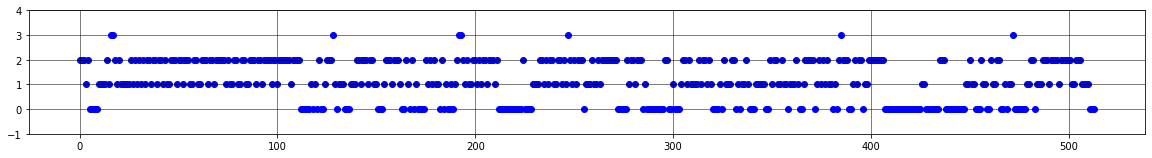

6NM6yahoo


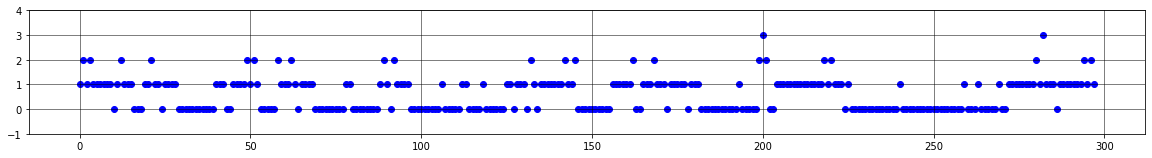

7NM3miyazaki


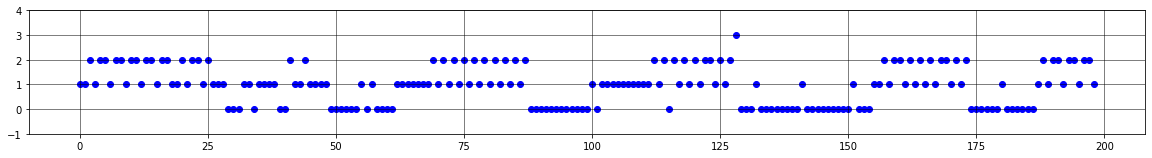

5NM4tsukky


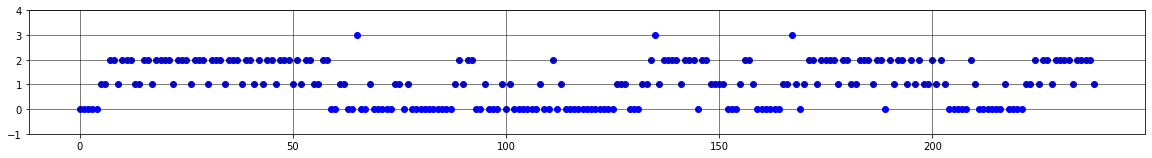

6NM7kobeG


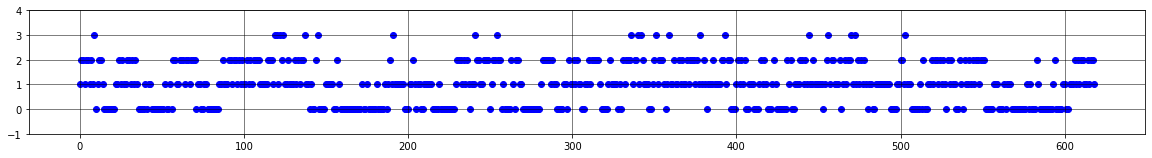

6NM1yossi


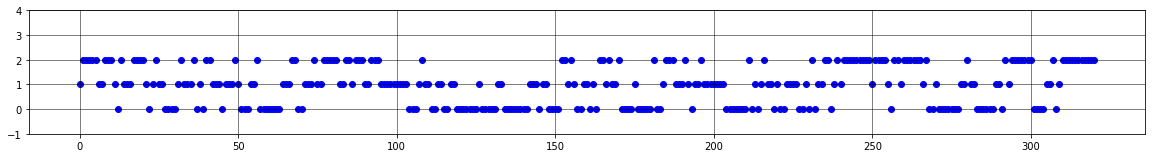

7NM5yakkun


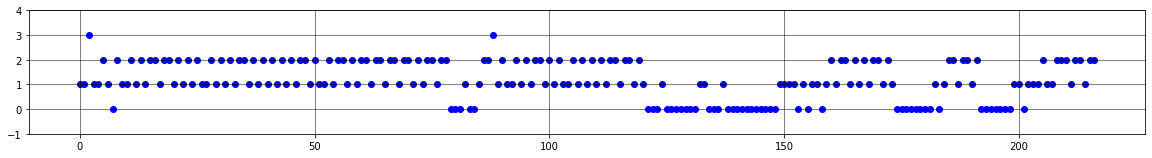

5NM8shishamo


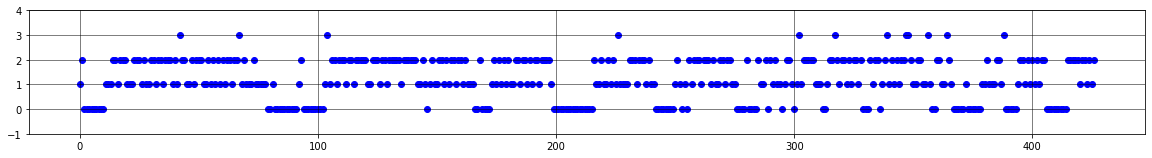

7NM2toshiki


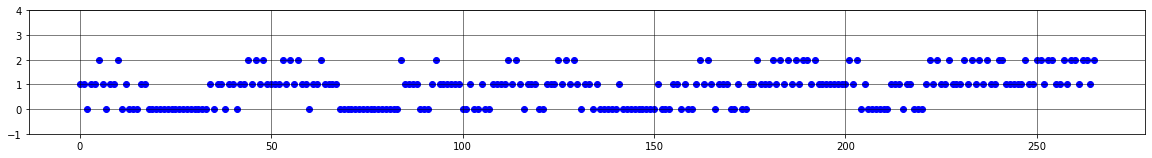

5NM8kan


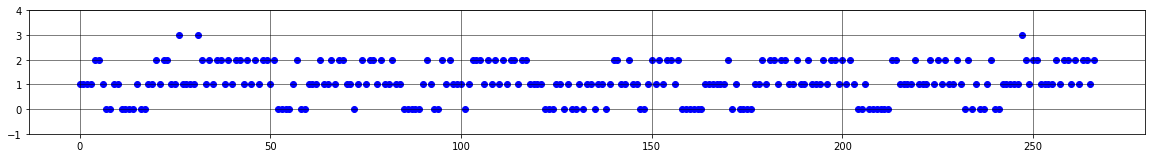

6NM6kobeH


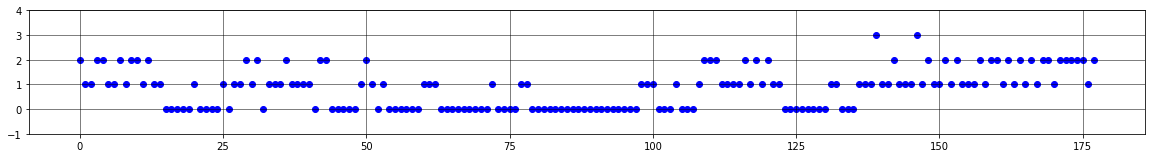

6NM6nishio


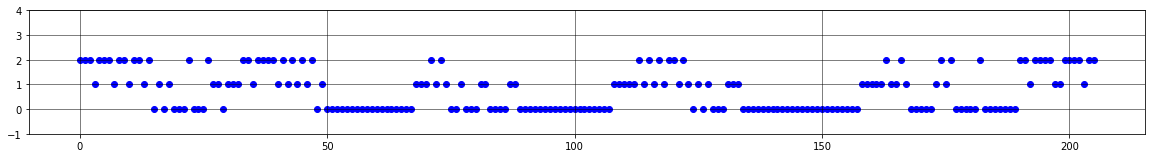

7NM3zimotoE


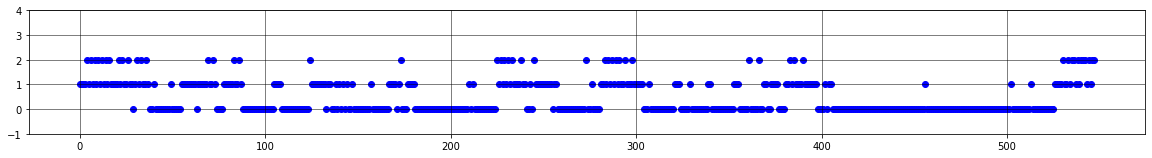

6NM7tamuchin


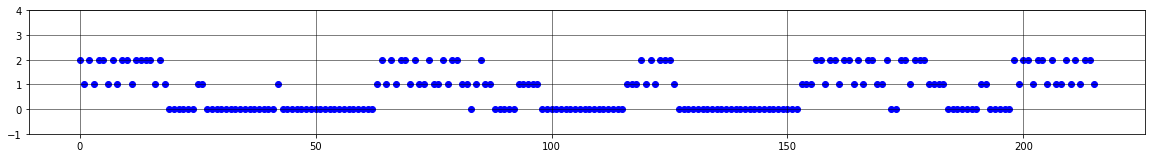

6NM3kobeC


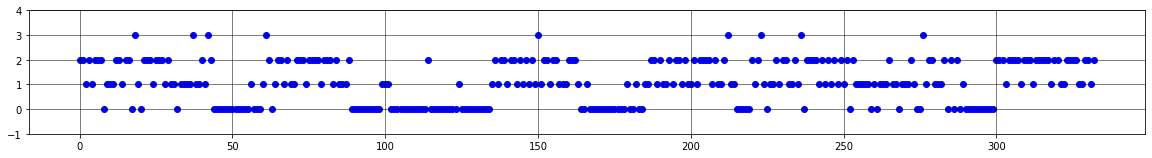

6NM4kobeI


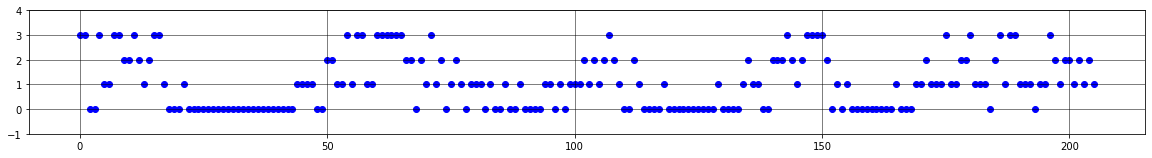

6NM5kobeD


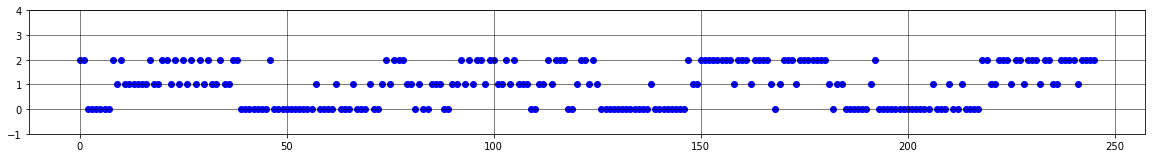

7NM4zimotoD


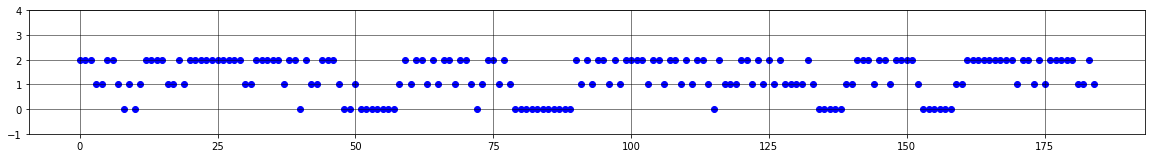

6NM5kobeF


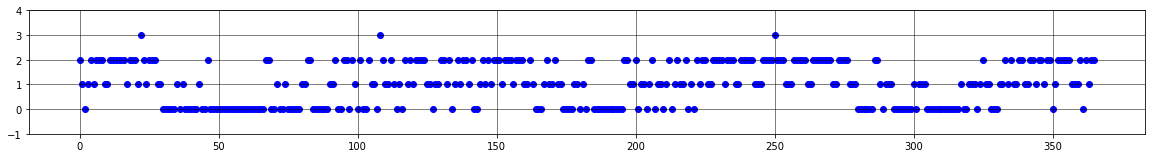

7NM7yakkun


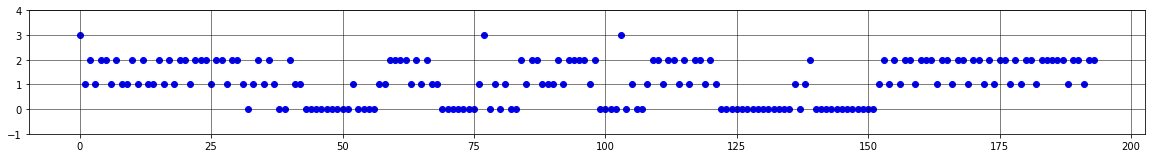

7NM9zimotoB


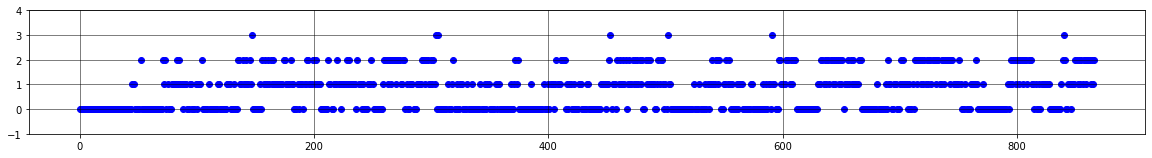

6NM5yahoo


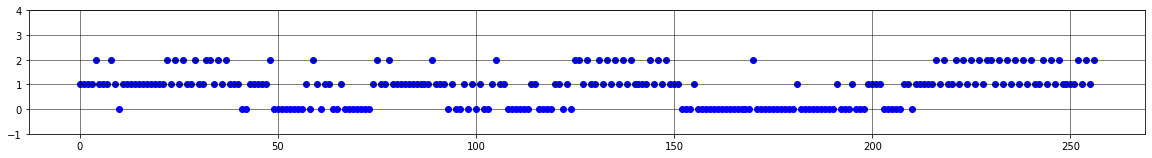

6NM2kobeB


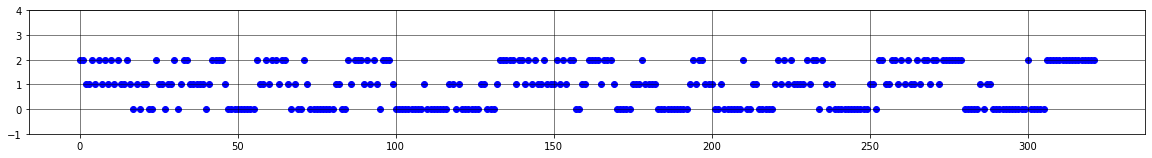

7NM5zimotoA


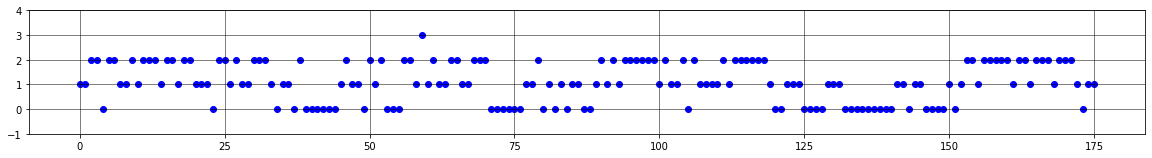

6NM6tamuchin


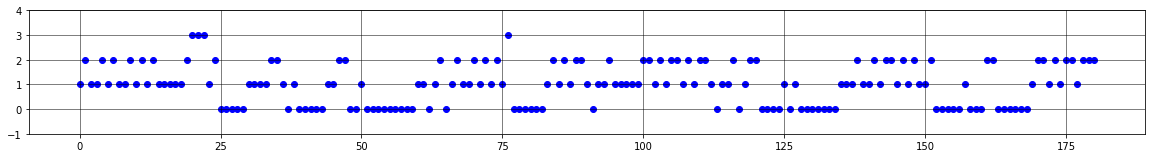

7NM8zimotoC


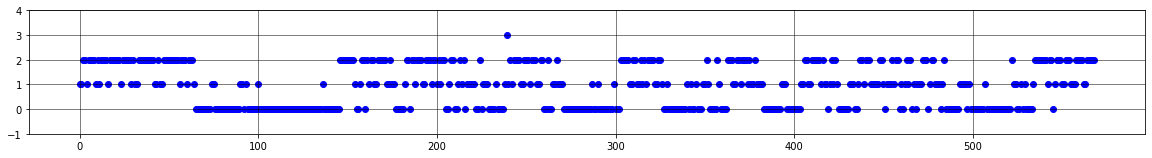

5NMEXTRAharasho


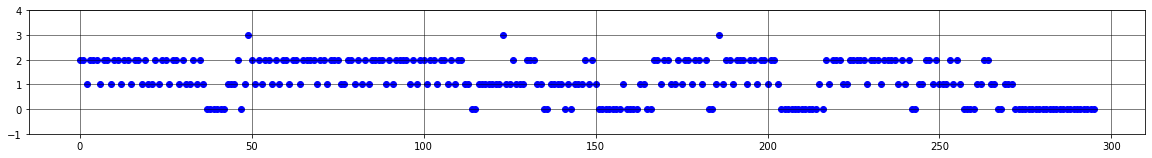

6NM6kobeA


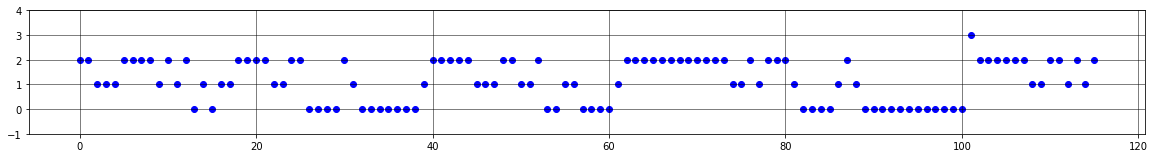

7NM7zimotoD


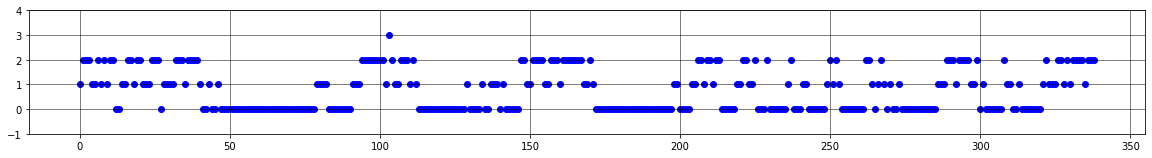

7NM6koho


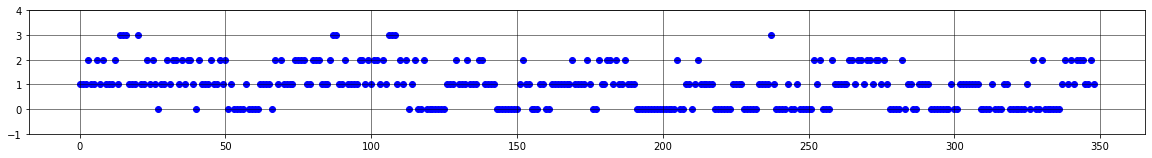

7NM1koho


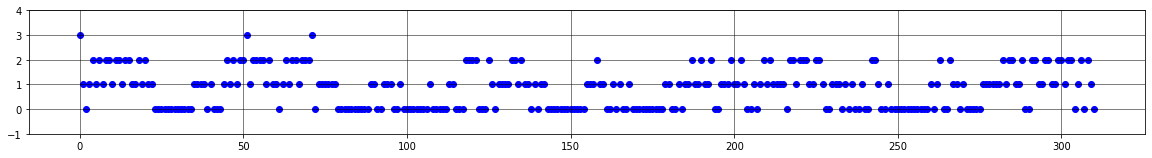

7NM6zimotoE


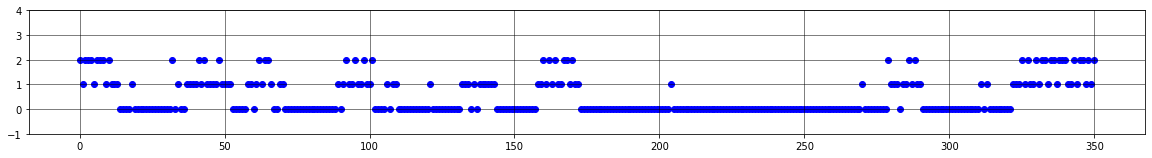

6NM9nishio


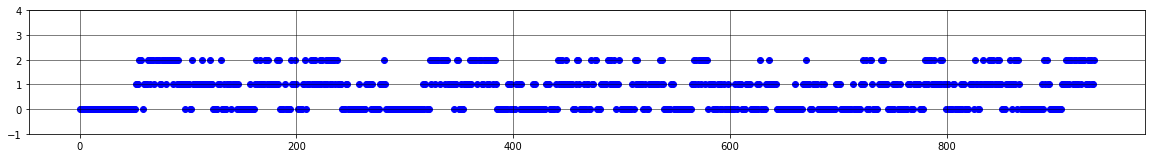

5NM1shibataku


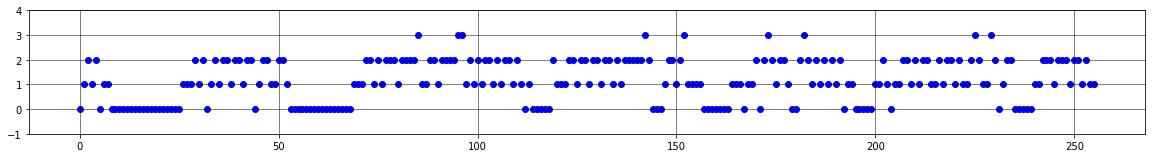

7NM1miyazaki


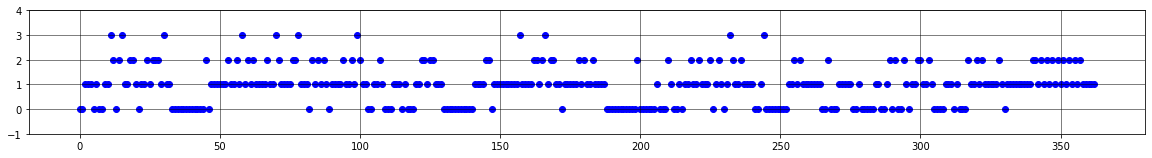

6NM9senkita


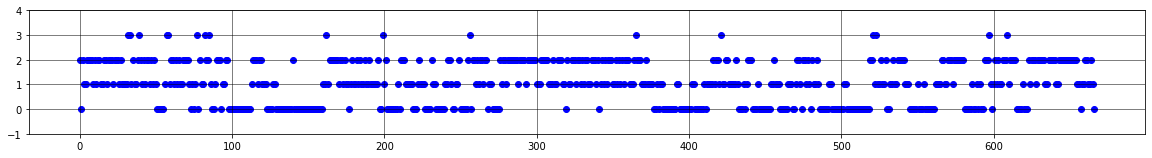

7NM5zimotoC


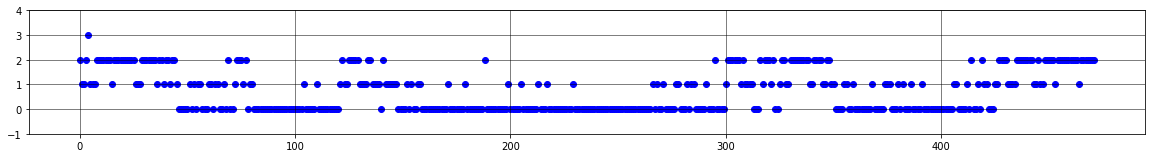

6NM2tamuchin


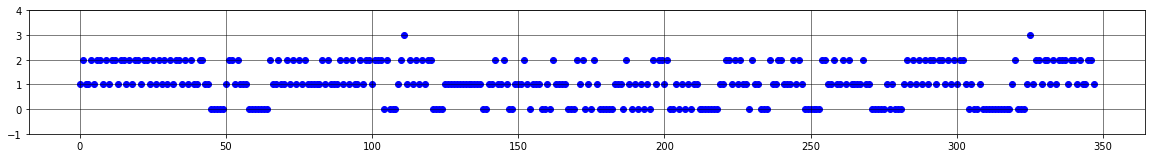

5NM4tiger


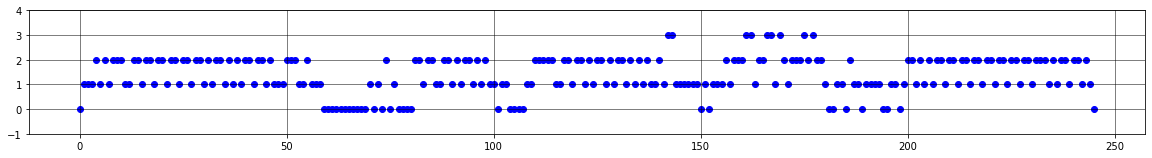

6NM5tamuchin


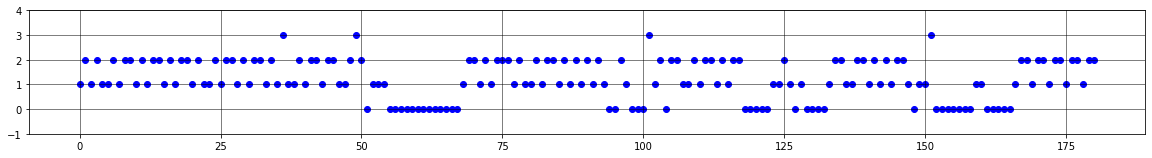

7NM2zimotoD


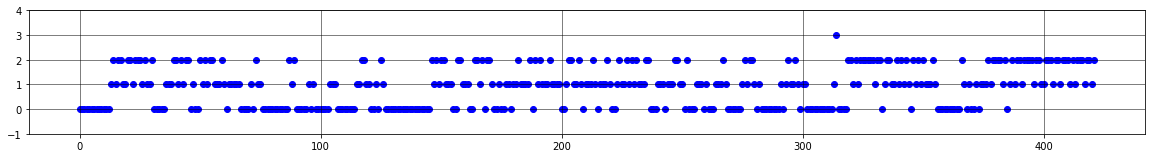

7NM2miyazaki


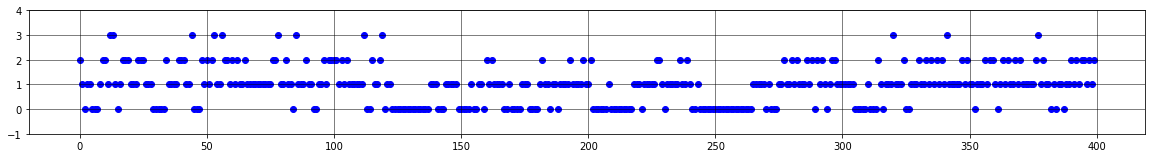

6NM4kobeD


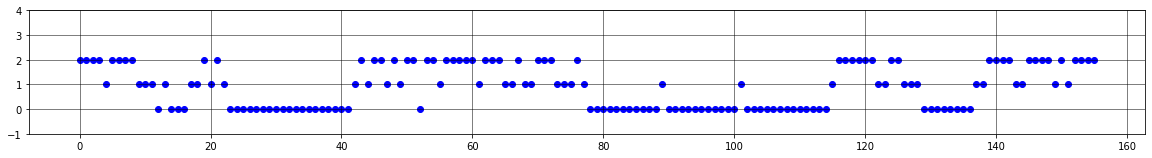

5NM4yahoo


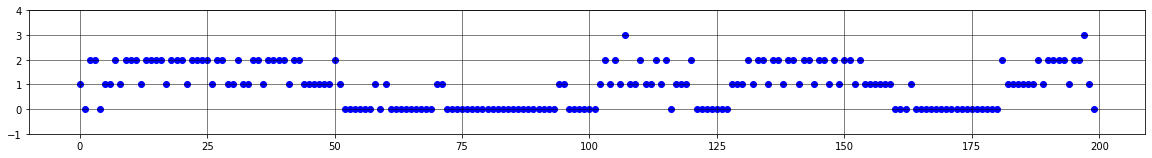

7NM7zimotoE


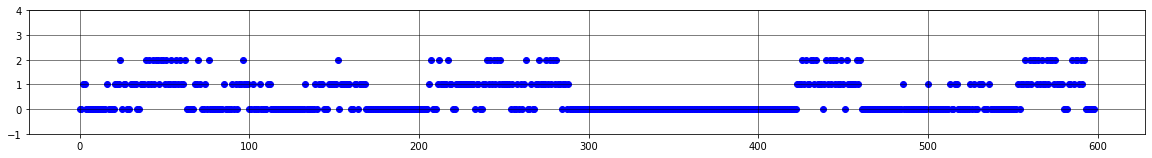

6NM8kobeI


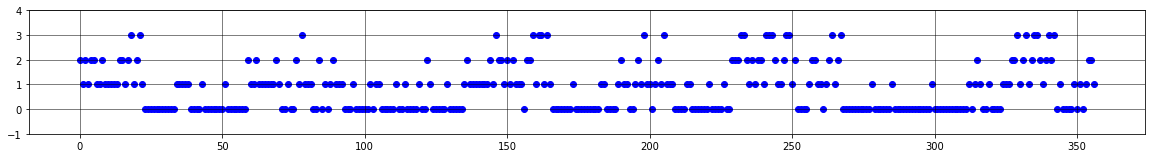

7NM9yakkun


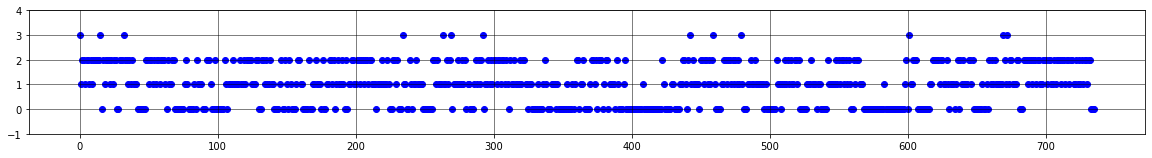

7NM9miyazaki


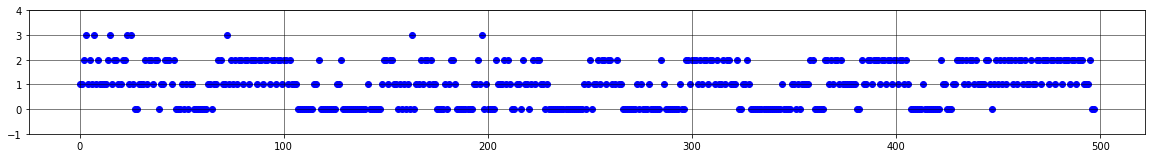

6NM2kobeG


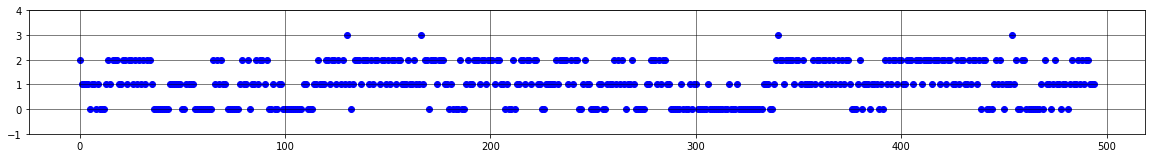

5NM2tiger


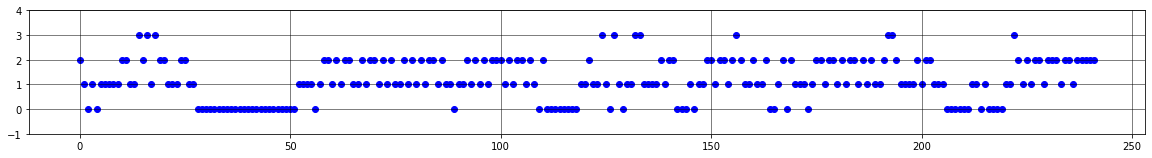

5NM9yahoo


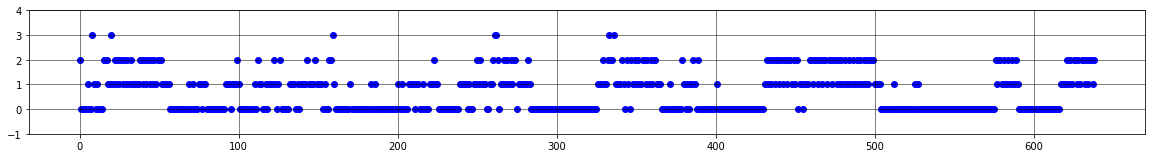

6NM3tamuchin


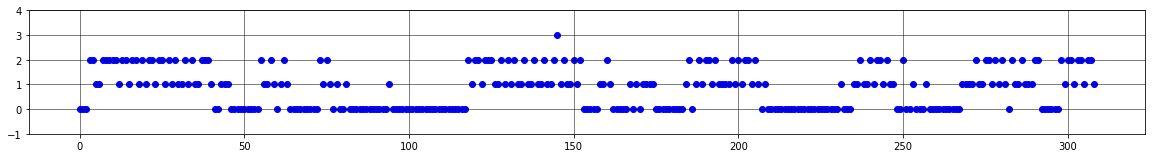

6NM9tamuchin


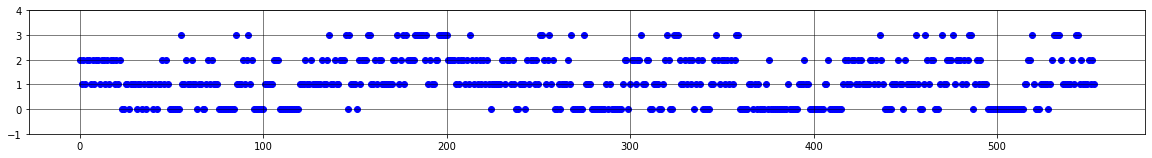

6NM3kobeH


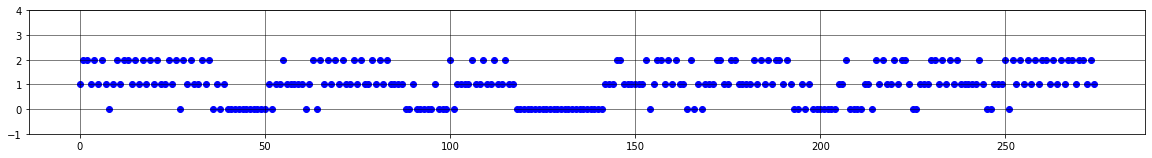

6NM8tsubouchi


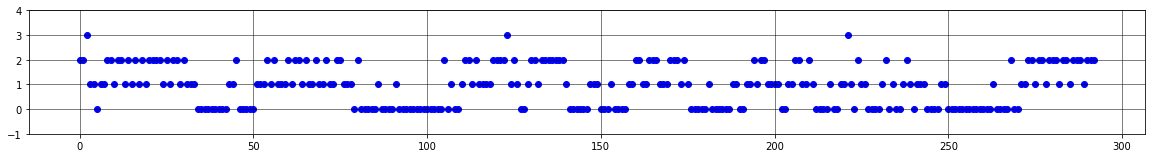

7NM1zimotoA


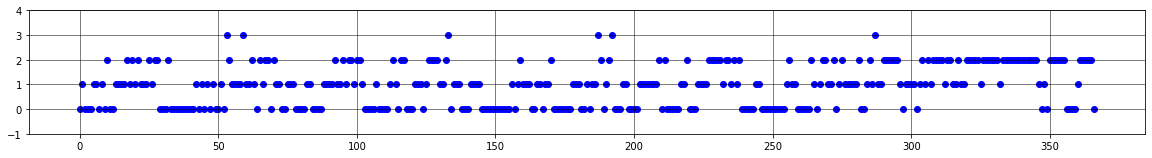

6NM4tsubouchi


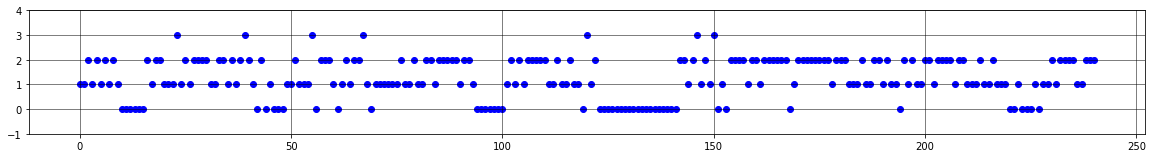

7NM6zimotoB


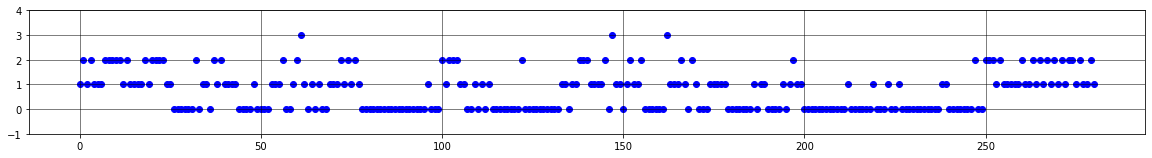

7NM4zimotoE


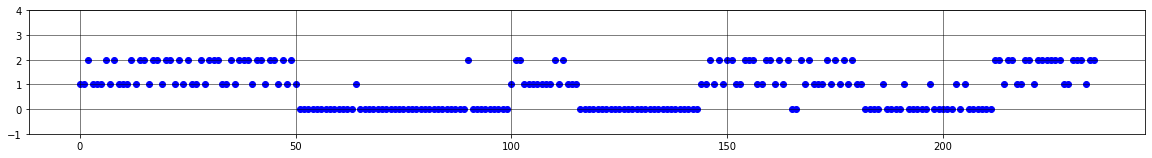

7NM3zimotoA


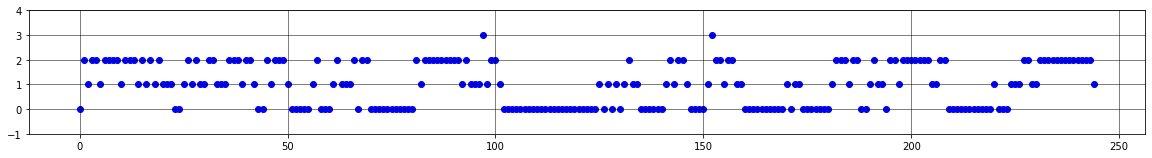

6NM8yahoo


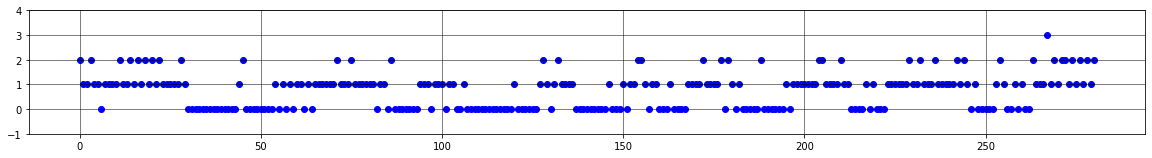

6NM1kobeA


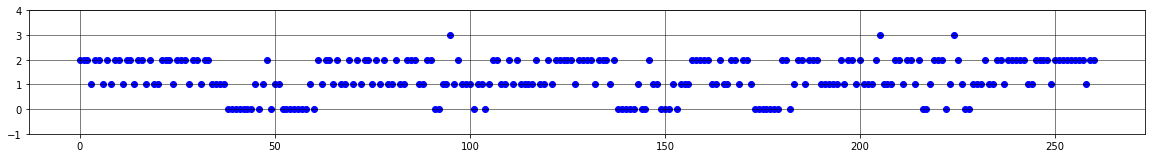

5NM4arthur


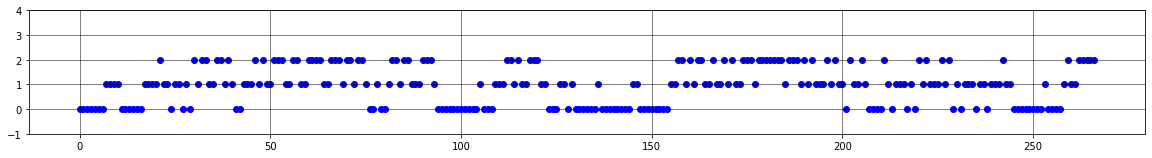

7NM8zimotoB


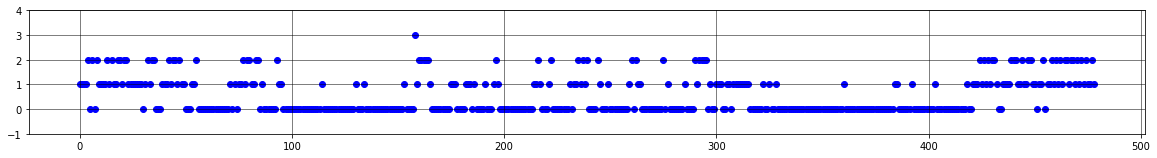

7NM5miyazaki


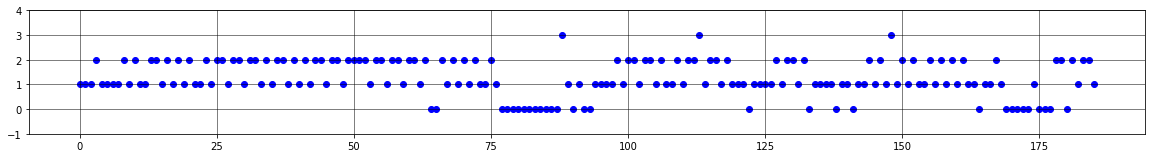

6NM8kobeC


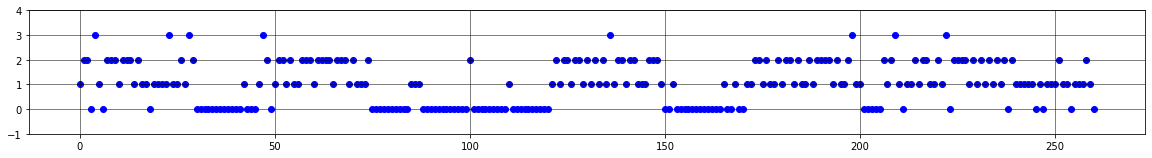

5NM7shibataku


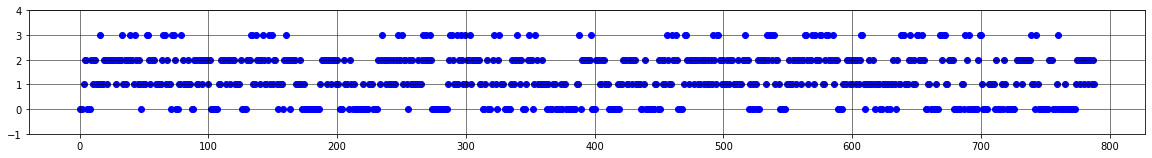

7NM2zimotoC


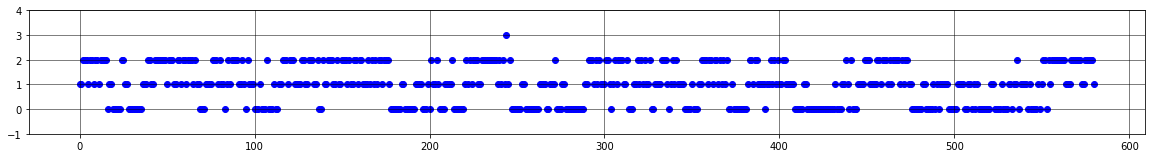

7NM2zimotoB


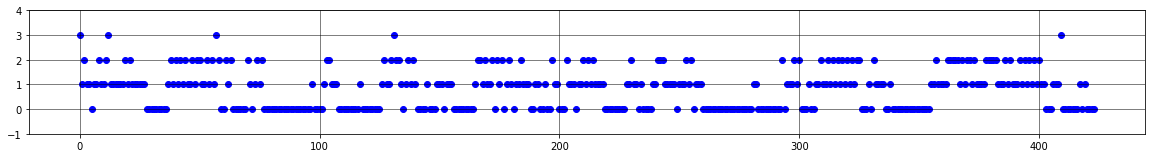

7NM5toshiki


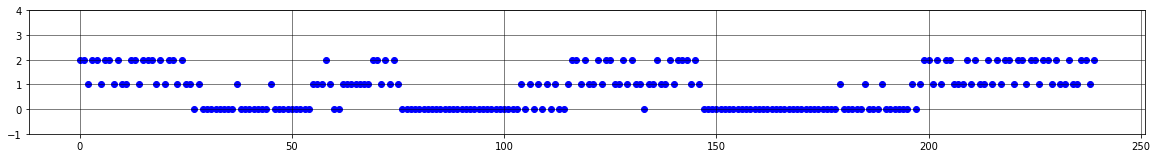

7NM4miyazaki


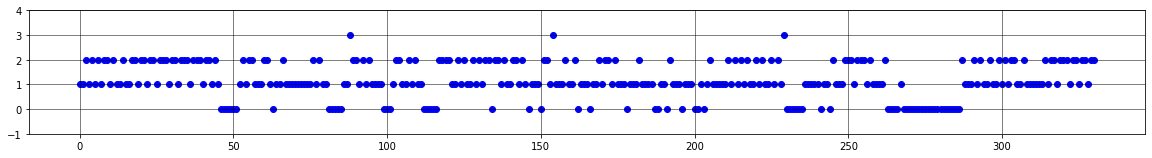

7NM7miyazaki


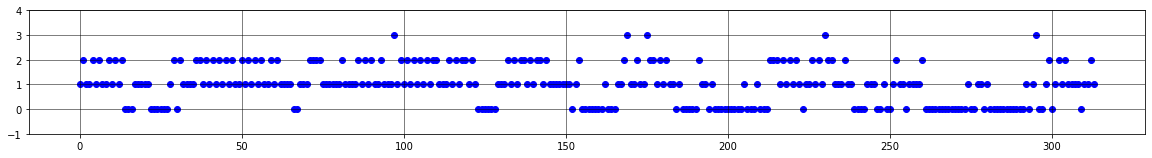

6NM7kobeB


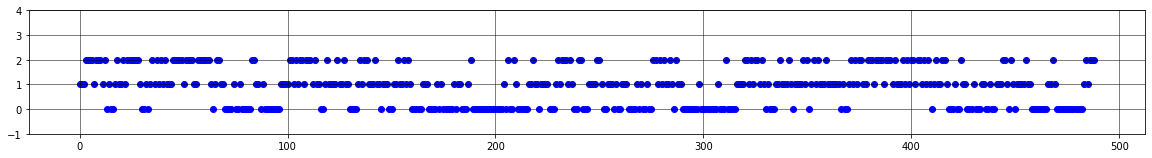

7NM9zimotoA


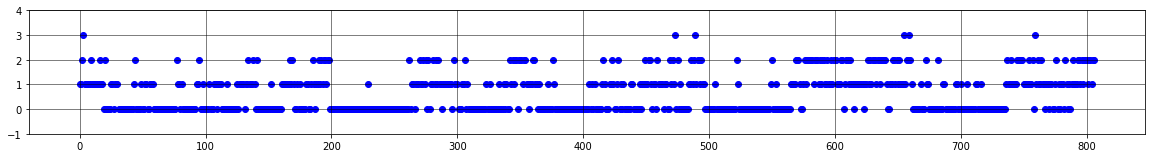

6NM1senkita


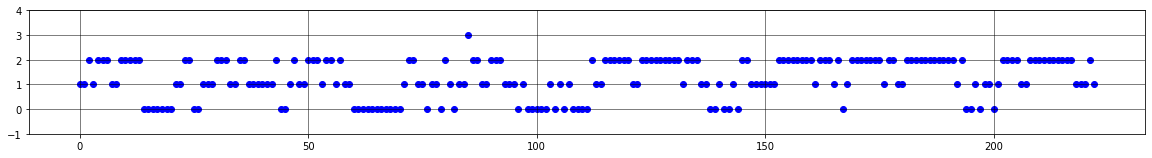

6NM8tamuchin


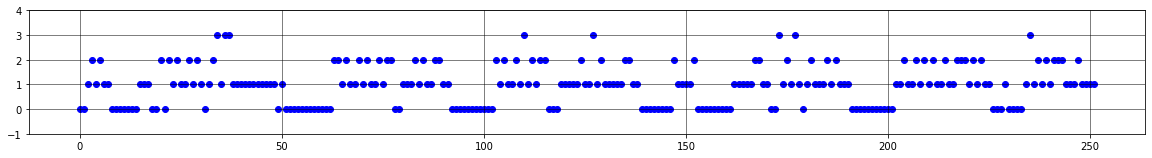

7NM4zimotoB


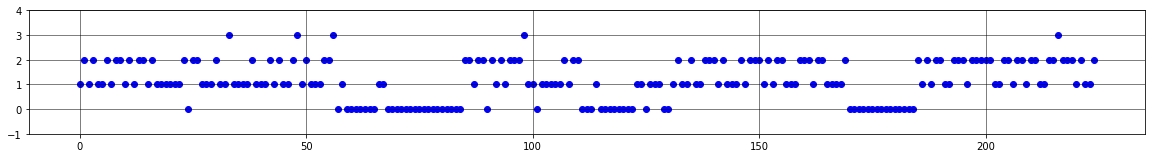

6NM5kobeE


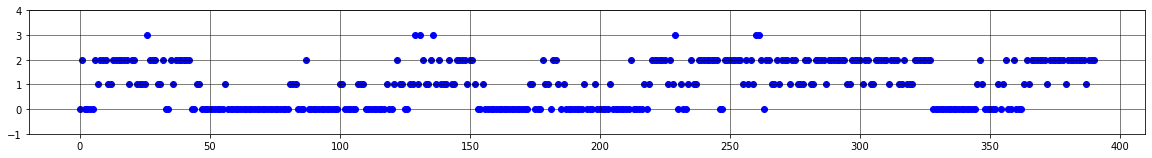

6NM9ganpon


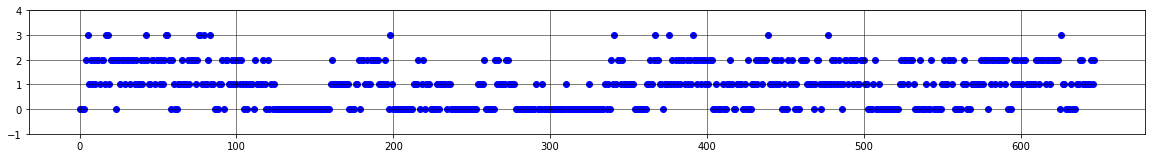

7NM8miyazaki


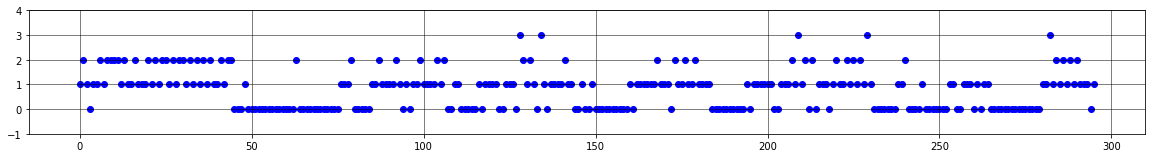

6NM1kobeE


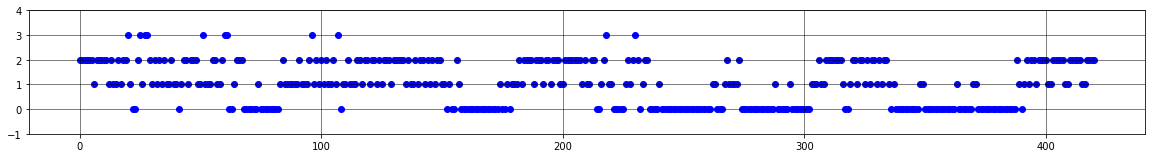

In [7]:
SENSOR="Accelerometer"
w=1.2

for file in glob.glob("../../etc/label/*.csv"):
    file_name=os.path.basename(file).split(".csv")[0]
    print(file_name)
    new_df=pd.DataFrame()
    count=0
    df=pd.read_json("../../etc/no_header_pdr_raw_data/{}.json".format(file_name), orient='records', lines=True)
    label=pd.read_csv("../../etc/label/{}.csv".format(file_name), header=None)    

    acc_sencor=df[df['type']==SENSOR]
    times=acc_sencor['unixTime']
    START_TIME=label[0][0]
    END_TIME=label[0][len(label)-1]

    x, y, z=acc_sencor['x'], acc_sencor['y'], acc_sencor['z']
    com_acc=[]
    for value in zip(x, y, z):
        com_acc.append(math.sqrt(value[0]**2 + value[1]**2 + value[2]**2))
    time_count=getTimeCount(times)

    f2=lowPass(wave=com_acc, fc=3, dt=0.005)

    for ti in range(START_TIME, END_TIME+1, 1):
        S=sum(time_count[:ti])
        f=f2[S-int((200*w)):S]
        time=times[S-int((200*w)):S]
        SC=step_count(f, time, 1)
        new_df=new_df.append({"user":file_name, "label":label[1][count], "SC":SC}, ignore_index=True)
        count+=1
    steps=new_df['SC'].values
    fig = plt.figure(figsize=(20, 5))
    ax=fig.add_subplot(2, 1, 1, ylim=(-1,4))
    ax.grid(axis='x', color='black', lw=0.5)
    ax.grid(axis='y', color='black', lw=0.5)
    ax.scatter(list(range(len(steps))), steps, color='blue')
    plt.show()